# Inverse Problems

## Blur + Noise reconstruction

Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import equinox as eqx
import jax 
import jax.scipy as jsp
import jax.numpy as jnp
import helper as hlp
from tqdm import tqdm
import optax 
from functools import partial
%matplotlib inline
%load_ext autoreload
%autoreload 2

Working images 

- Version 1: without periodic padding

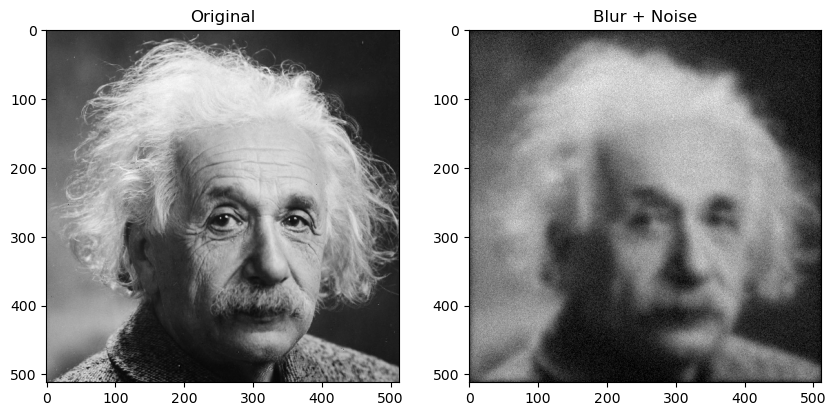

In [2]:
# original img 
img = ski.io.imread('data/img/einstein.tif').astype(np.float32)
img = (img - img.min()) / np.ptp(img) # Normalize float image to [0, 1] instead of [0, 255]
img /= np.sqrt(np.sum(img**2))  # make unit energy

# blurred img 
gaussian_kernel = hlp.get_2D_Gaussian_kernel(5)
gaussian_kernel /= np.sqrt(np.sum(gaussian_kernel**2)) # make unit energy
blur_img = jsp.signal.convolve(img,gaussian_kernel, mode='same')

# noisy img --> build noise from SNR
seed = 4
rng = np.random.default_rng(seed)  ###### change to jax RNG 
SNR_dB = 20 # target SNR
SNR = 10 ** (SNR_dB / 10)
E_sig = np.sum(blur_img**2)  # energy in the signal
E_noise = E_sig / SNR
gaussian_noise = np.sqrt(E_noise / img.size) * rng.standard_normal(img.shape)
blur_noise_img = blur_img + gaussian_noise
blur_noise_img= np.clip(blur_noise_img, 0, None) ##################### why None ?

# plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize =(10,10))
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
plt.show()

- Version 2: with periodic padding

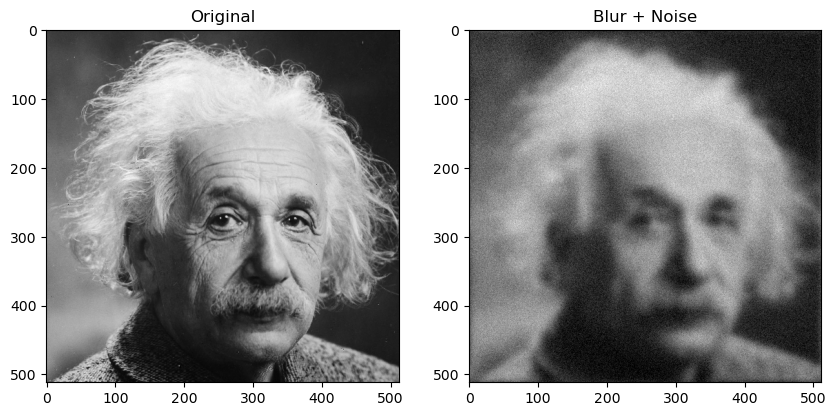

In [2]:
# original img 
img = ski.io.imread('data/img/einstein.tif').astype(np.float32)
img = (img - img.min()) / np.ptp(img) # Normalize float image to [0, 1] instead of [0, 255]
img /= np.sqrt(np.sum(img**2))  # make unit energy

# blurred kernel
gaussian_kernel = hlp.get_2D_Gaussian_kernel(5)
gaussian_kernel /= np.sqrt(np.sum(gaussian_kernel**2)) # make unit energy

# perform convolution in Fourrier space by considering periodic padding
img_kernel = hlp.kernel_to_image(gaussian_kernel, img )
img_kernel_f = jnp.fft.fft2(img_kernel)
img_f = jnp.fft.fft2(img) 
per_blur_img_f = jnp.multiply(img_kernel_f, img_f)

# go back into space domain
per_blur_img = jnp.fft.ifft2(per_blur_img_f).real

# noisy img --> build noise from SNR
seed = 4
rng = np.random.default_rng(seed)  ###### change to jax RNG 
SNR_dB = 20 # target SNR
SNR = 10 ** (SNR_dB / 10)
E_sig = np.sum(per_blur_img**2)  # energy in the signal
E_noise = E_sig / SNR
gaussian_noise = np.sqrt(E_noise / img.size) * rng.standard_normal(img.shape)
per_blur_noise_img = per_blur_img + gaussian_noise
per_blur_noise_img= np.clip(per_blur_noise_img, 0, None) ##################### why None ?


# plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize =(10,10))
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(per_blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
plt.show()

Reconstruction

- model 1: corresponding to version 1 without padding

In [4]:
class Model(eqx.Module):
    kernel: jnp.ndarray
    # y: jnp.ndarray

    def __init__(self, kernel):
        self.kernel = kernel
        # self.y = y

    def __call__(self, x):
        Ax = jsp.signal.convolve(x,self.kernel, mode='same') # this convolution doesn't have periodic condition boundary
        return Ax
    

# loss function 
def loss(x, y, A): 
    loss = jnp.linalg.norm(y-A(x), ord = 'fro')**2
    return loss

# optimizer --> GD
@jax.jit  
def optimizer_step(x, y, A, alpha):  # alpha = learning rate
    loss_val, grads_val = jax.value_and_grad(loss)(x, y, A)
    # print(grads_val)
    
    # GD update
    x_new = x - alpha * grads_val

    # projection
    # x_new = jnp.clip(x_new, 0, 255)

    return loss_val, x_new

In [ ]:
# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))


# optimization parameters
alpha = 1e-3 
n_iter = 100 


losses = []
# solve 
for _ in tqdm(range(n_iter)):
    loss_val, x = optimizer_step(x, y, A, alpha) 
    losses.append(loss_val)

100%|██████████| 100/100 [00:09<00:00, 10.45it/s]


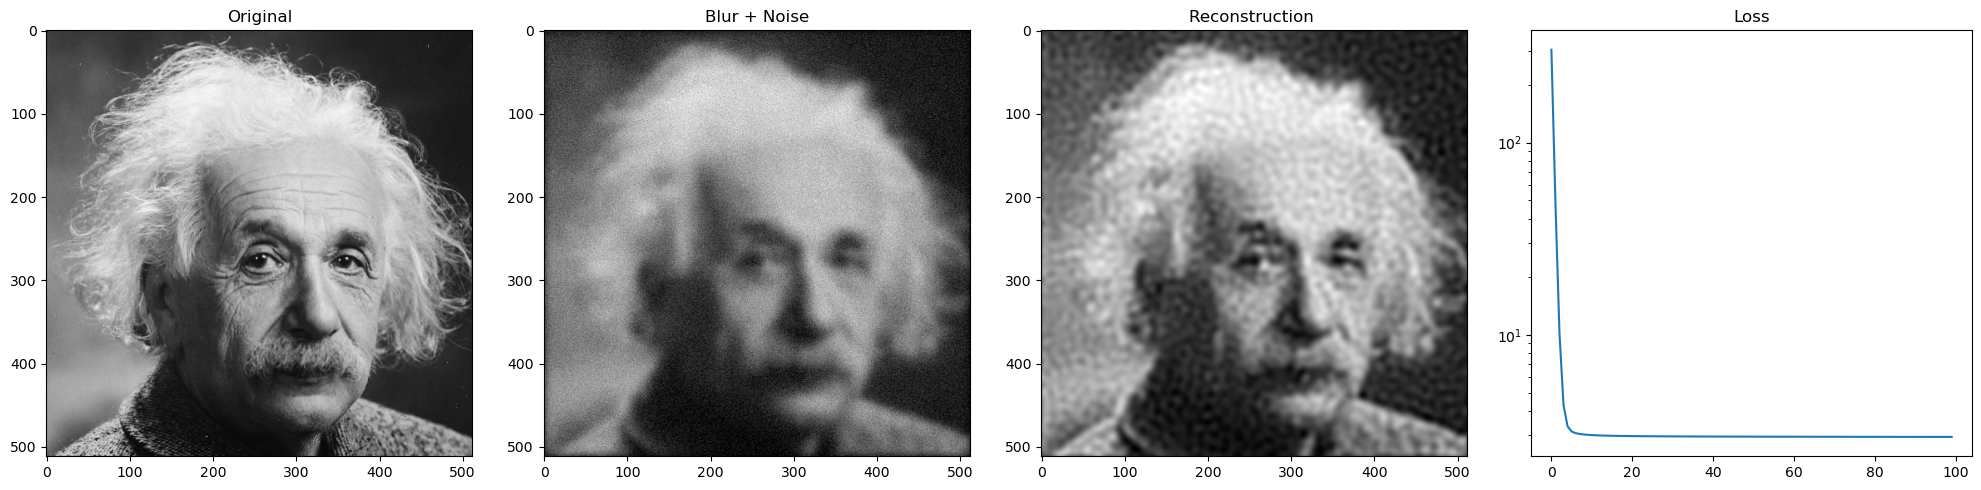

In [14]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.semilogy(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

with ADAM optimizer (still version 1 ie. without periodic padding)

In [19]:
# optimization parameters
alpha = 7
n_iter = 300


# optimizer --> ADAM
ADAM_optimizer = optax.adam(learning_rate=alpha)


def adam_optimizer_step(x, opt_state):
    loss_val, grads_val = jax.value_and_grad(loss)(x, y, A)
    
    # ADAM update
    updates, opt_state = ADAM_optimizer.update(grads_val, opt_state)
    x = optax.apply_updates(x, updates)

    # projection
    # x_new = jnp.clip(x_new, 0, 255)

    return x, opt_state, loss_val


# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))
opt_state = ADAM_optimizer.init(x)

losses = []
# solve 
for _ in tqdm(range(n_iter)):
    x, opt_state, loss_val  = adam_optimizer_step(x, opt_state) 
    losses.append(loss_val)

100%|██████████| 300/300 [00:43<00:00,  6.87it/s]


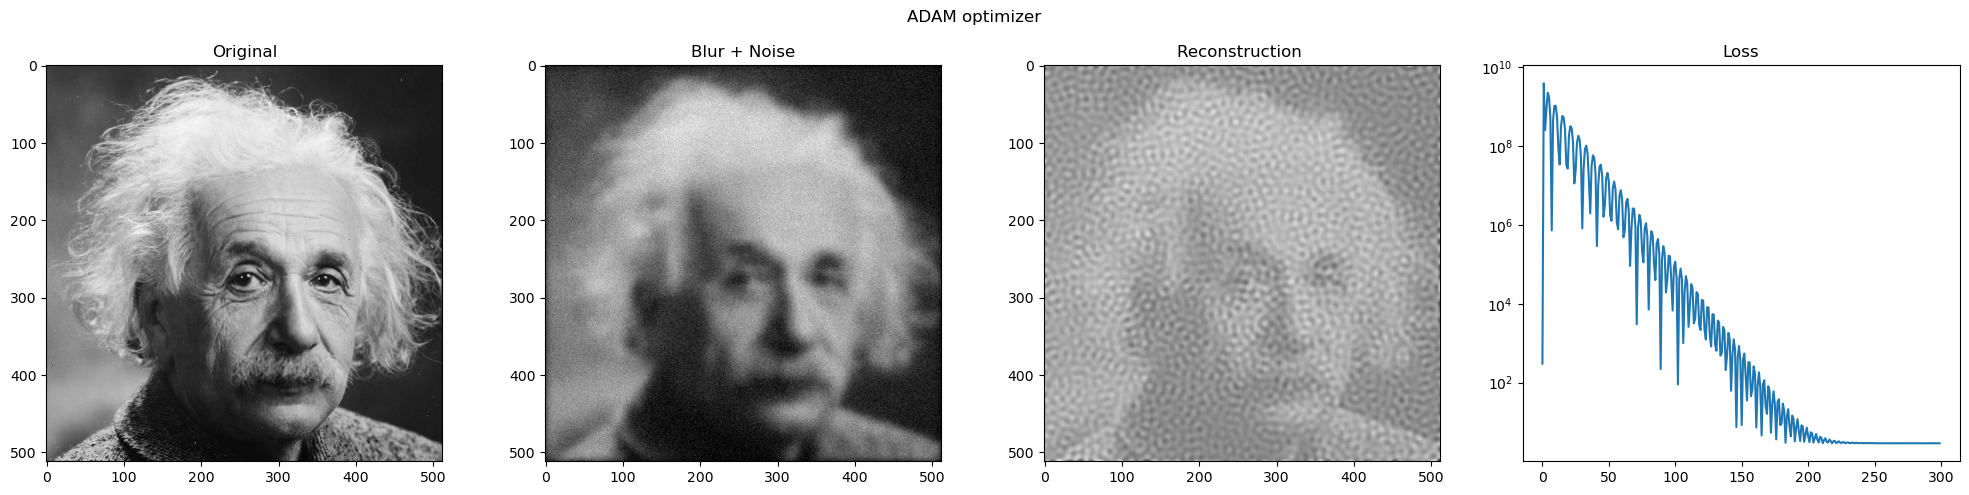

In [20]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('ADAM optimizer')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.semilogy(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

- model 2: corresponding to version 2 with periodic padding

In [4]:
class Model_periodic_padding(eqx.Module):
    img_kernel_f: jnp.ndarray

    def __init__(self, img_kernel):
        self.img_kernel_f = jnp.fft.fft2(img_kernel)

    def __call__(self, x):
        # dft
        x_f = jnp.fft.fft2(x) 

        # filtering
        Ax_f = jnp.multiply(self.img_kernel_f, x_f)

        # go back into space domain
        Ax = jnp.fft.ifft2(Ax_f).real

        return Ax

In [20]:
# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(per_blur_noise_img)
A = Model_periodic_padding(jnp.array(img_kernel))
L = jnp.max(jnp.abs(A.img_kernel_f))


# optimization parameters
# alpha = 1/L ####### fonctionne plus pq ? à cause du noise qui fait que le L que j'ai pris n'est pas le bon ?
alpha = 1e-3
n_iter = 100 
# n_iter = 10 



losses = []
# solve 
for _ in tqdm(range(n_iter)):
    loss_val, x = optimizer_step(x, y, A, alpha) 
    losses.append(loss_val)

100%|██████████| 100/100 [00:00<00:00, 232.69it/s]


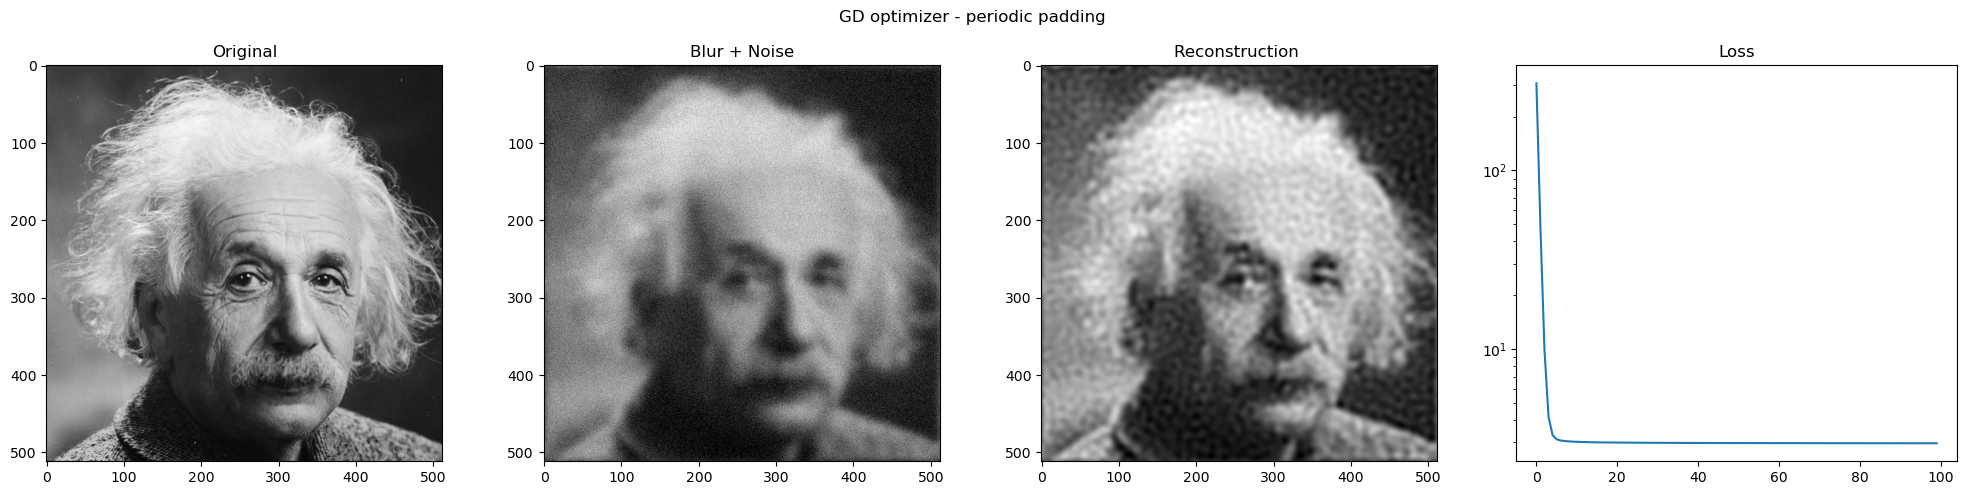

In [21]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('GD optimizer - periodic padding')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(per_blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.semilogy(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

### With regulizer 

- L2: \norm{x}{2}^{2} model 1 (without periodic padding)

In [6]:
# objectiv function : F(x) = f(x) + g(x)
# the problem can be written as argmin{f(x) + g(x)} where f(x) = ||y-Ax||{2}^{2} and g(x) = ||x||{2}^{2}
# since g(x) = ||x||^2_2 (is smooth and convex), we can just use the same procedure than before by just adding g(x) to the loss function

# loss function 
def loss_rL2(x, y, A, lam): 
    loss = jnp.linalg.norm(y-A(x), ord = 'fro')**2 + lam*jnp.linalg.norm(x)**2
    return loss

@jax.jit  
def optimizer_step_rL2(x, y, A, alpha, lam):  # alpha = learning rate
    loss_val, grads_val = jax.value_and_grad(loss_rL2)(x, y, A, lam)
    
    # GD update
    x_new = x - alpha * grads_val

    return loss_val, x_new

In [7]:
# initialisation 
x = jnp.zeros(img.shape) + 1e-5 # doesn't work if i take 0 ############# find why
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))


# optimization parameters
alpha = 1e-3
n_iter = 100 
lam = 100 ######## is it exessively too high ?

losses = []
# solve 
for _ in tqdm(range(n_iter)):
    loss_val, x = optimizer_step_rL2(x, y, A, alpha, lam) 
    losses.append(loss_val)

100%|██████████| 100/100 [00:09<00:00, 10.43it/s]


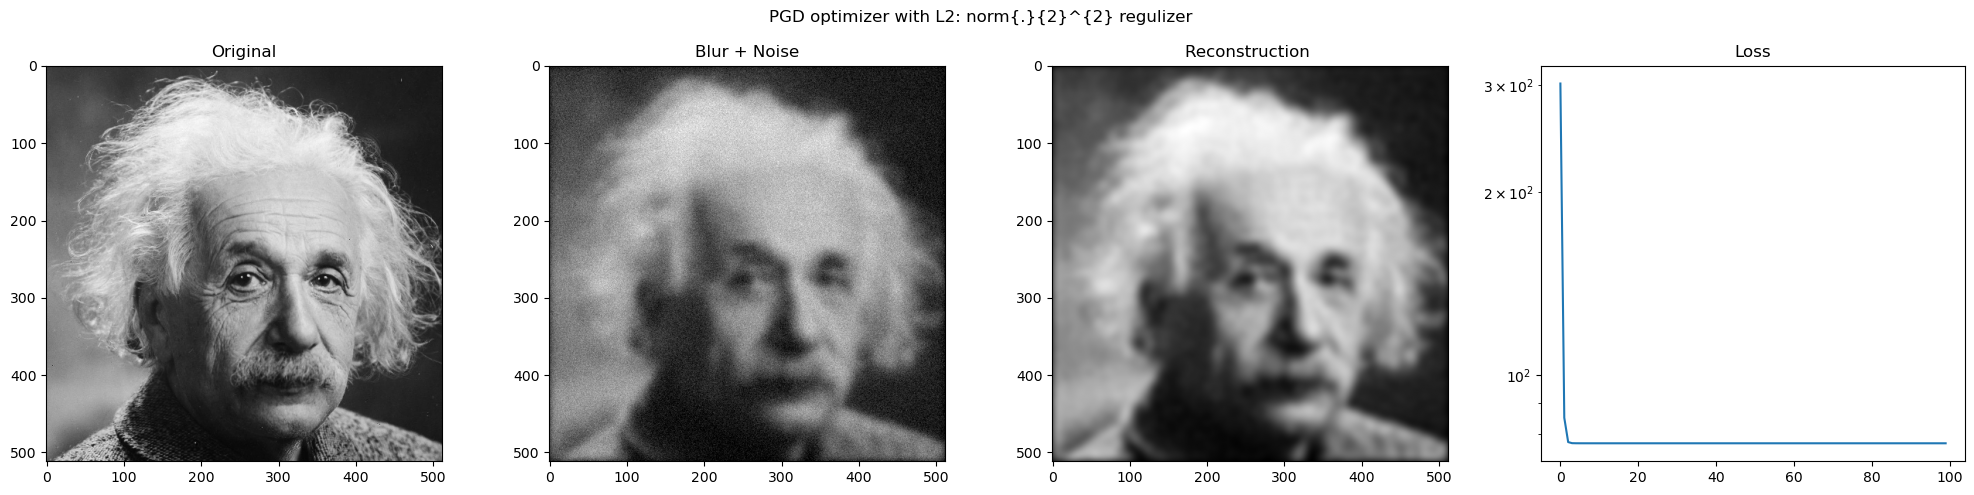

In [8]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('PGD optimizer with L2: norm{.}{2}^{2} regulizer')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.semilogy(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

- L2: \norm{x}{2}^{2}, model 2 (with periodic padding)

In [112]:
# initialisation 
x = jnp.zeros(img.shape) + 1e-5
y = jnp.array(per_blur_noise_img)
A = Model_periodic_padding(jnp.array(img_kernel))


# optimization parameters
alpha = 1e-3
n_iter = 100
lam = 100

losses = []
# solve 
for _ in tqdm(range(n_iter)):
    loss_val, x = optimizer_step_rL2(x, y, A, alpha, lam) 
    losses.append(loss_val) 

100%|██████████| 100/100 [00:00<00:00, 228.51it/s]


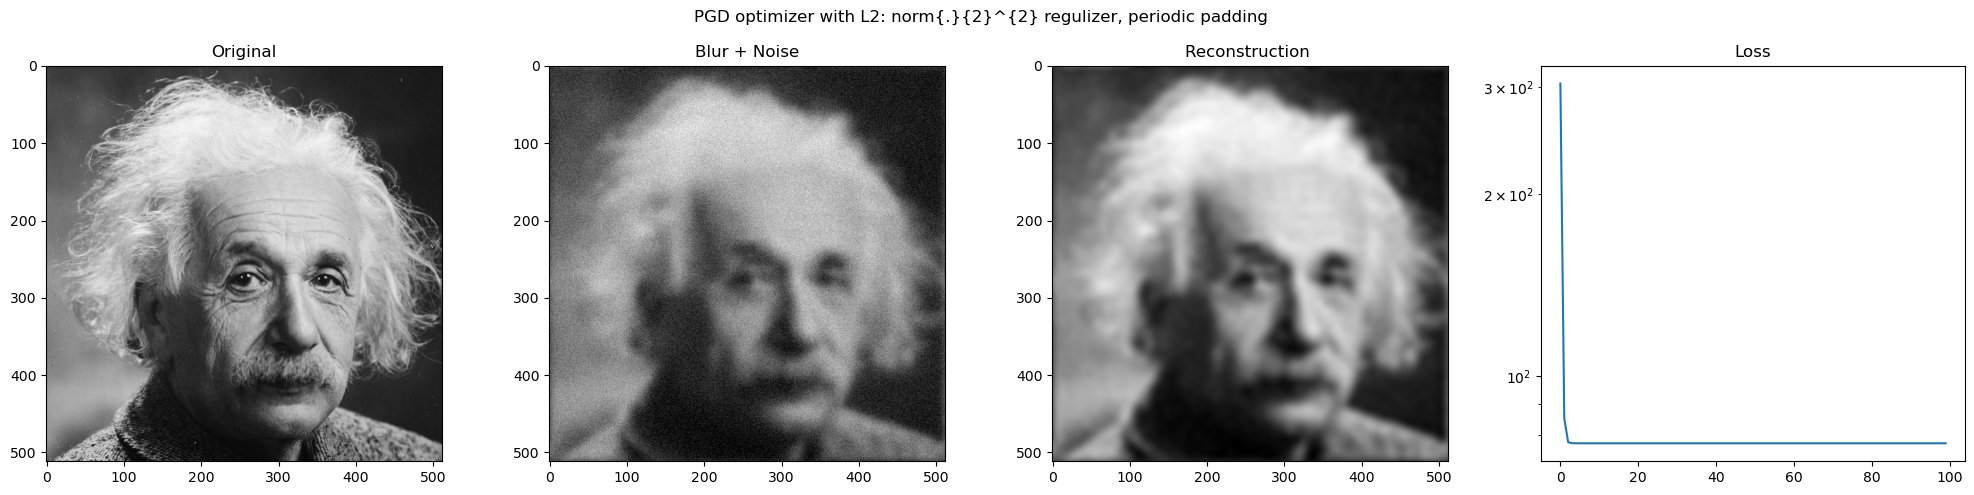

In [113]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('PGD optimizer with L2: norm{.}{2}^{2} regulizer, periodic padding')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(per_blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.semilogy(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

- Comments :

for alpha = 1e-3, the algorithm converge fast towards 10^0 (loss value) however the final reconstruct image contains some "points" in it

for alpha = 1e-8 the result is visualy better (without point but more blurry) but the loss is higher. Furthermore, one must increase the number of iteration (above 20000 it). 

With l2 regularizer lamda != 0:
"visually" lamda make the point disapear when alpha is small (1e-3) and nbr iteration small too (less than 100 it) however, the value of lamda has to be increased (around 100 for alpha = 1e-3) and the loss is a bit higher a the final step. 

Finally, there is no more differencies between convolution with periodic padding and zero padding. This is due to the fact that the gaussian kernel has been reduced by taking a variance = 5.

Since the result are quite the same, for the following notebook, i'll consider only the peridodic padding version since the computation is a lot more faster !




- L1: \Norm{x}{1}, model 1: without periodic padding

In [ ]:
# # here g(x) = ||x||{1} is not smooth anymore. To solve inverse problem we use PGD with a proximal step
# def f(x, y, A):
#     fx = jnp.linalg.norm(y-A(x), ord = 'fro')**2
#     return fx

# def g(x):
#     gx = jnp.sum(jnp.abs(x))
#     return gx

# # PGD opitmizer
# @jax.jit
# def L1_optimizer_step(x, y, A, alpha, tau):  # alpha = step size
#     grads_val = jax.grad(f)(x, y, A)
#     # print(grads_val)
    
#     # GD update
#     z = x - alpha * grads_val
#     # print(z)
#     # proximal step (soft threshold since is g(x) = ||x||{1})
#     x_new = jnp.sign(z)*jnp.maximum(jnp.abs(z)-tau, 0.0)
#     # print(x_new)

#     # projection
#     # x_new = jnp.clip(x_new, 0, 255)
    
#     # diff objectiv value 
#     Fx_new = f(x_new,y, A) + g(x_new)
#     return x_new, Fx_new

In [ ]:
# # init
# x = jnp.zeros(img.shape)
# y = jnp.array(blur_noise_img)
# A = Model(jnp.array(gaussian_kernel))
# # L = jnp.max(jnp.abs(A.img_kernel_f))

# Fx_true = f(img, y, A) + g(img)
# Fx_init = f(x, y, A) + g(x)
# error = []
# error.append(Fx_init-Fx_true)

# # optimization parameters
# alpha = 0.5
# lam = 0.1
# tau = alpha*lam
# n_iter = 200

# # # solve 
# for _ in tqdm(range(n_iter)):
#     x, Fx = L1_optimizer_step(x, y, A, alpha, tau) 
#     error.append(Fx-Fx_true)

100%|██████████| 200/200 [08:16<00:00,  2.48s/it]


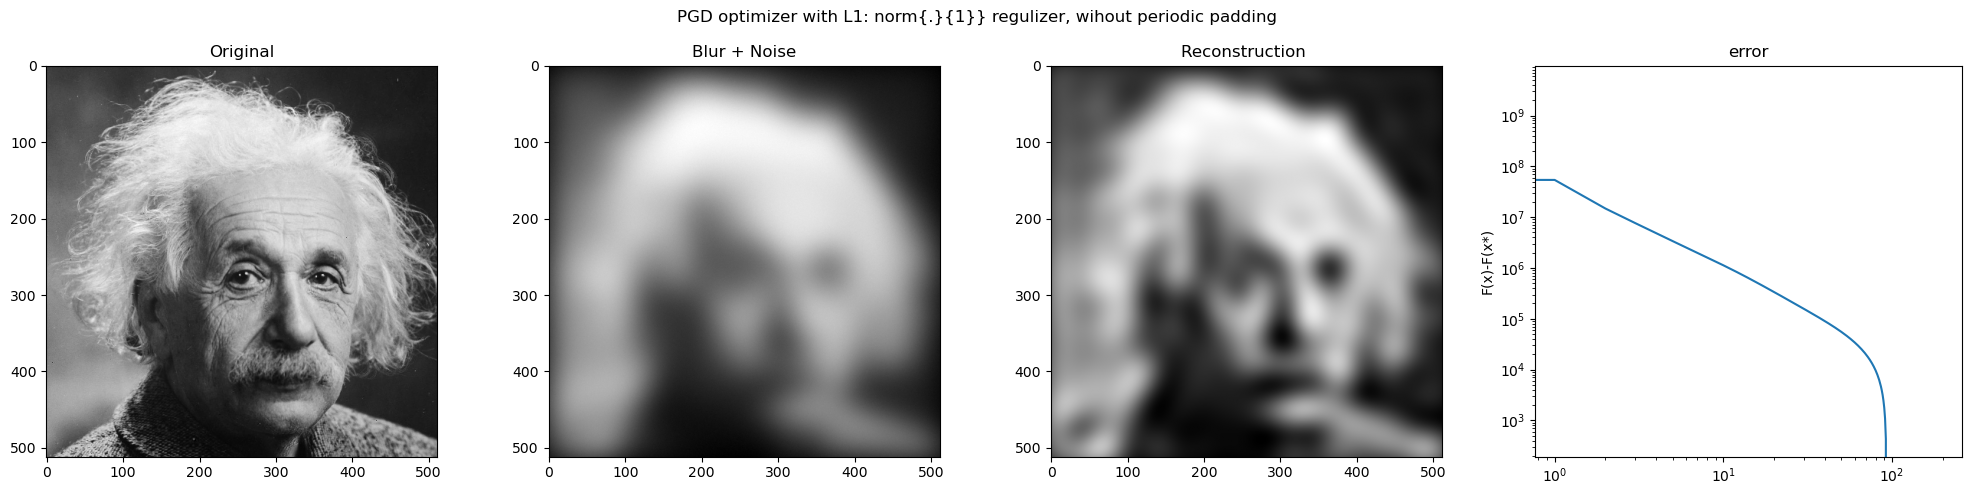

In [ ]:
# # plot
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
# fig.suptitle('PGD optimizer with L1: norm{.}{1}} regulizer, wihout periodic padding')
# ax1.imshow(img, cmap= "gray")
# ax1.set_title('Original')
# ax2.imshow(blur_noise_img, cmap= "gray")
# ax2.set_title('Blur + Noise')
# ax3.imshow(x, cmap= "gray")
# ax3.set_title('Reconstruction ')
# ax4.loglog(error)
# ax4.set_title('error')
# ax4.set_ylabel('F(x)-F(x*)')
# plt.tight_layout()
# plt.show()

- L1: \Norm{x}{1}, model 2: with periodic padding

In [102]:
# here g(x) = ||x||{1} is not smooth anymore. To solve inverse problem we use PGD with a proximal step
def f(x, y, A):
    fx = jnp.linalg.norm(y-A(x), ord = 'fro')**2
    return fx

def g(x):
    gx = jnp.sum(jnp.abs(x))
    return gx

# PGD opitmizer
@jax.jit
def L1_optimizer_step(x, y, A, alpha, tau):  # alpha = step size
    grads_val = jax.grad(f)(x, y, A)
    
    # GD update
    z = x - alpha * grads_val

    # proximal step (soft threshold since is g(x) = ||x||{1})
    x_new = jnp.sign(z)*jnp.maximum(jnp.abs(z)-tau, 0.0)

    
    # diff objectiv value 
    Fx_new = f(x_new,y, A) + g(x_new)
    return x_new, Fx_new

In [154]:
# init
x = jnp.zeros(img.shape)
y = jnp.array(per_blur_noise_img)
A = Model_periodic_padding(jnp.array(img_kernel))
Fx_true = f(img, y, A) + g(img)
Fx_init = f(x, y, A) + g(x)
error = []
error.append(np.abs(Fx_init-Fx_true))

# optimization parameters
L = jnp.max(jnp.abs(A.img_kernel_f))
alpha = 1e-5
lam = 1e-4
tau = alpha*lam
n_iter = 1234

# solve 
for _ in tqdm(range(n_iter)):
    x, Fx = L1_optimizer_step(x, y, A, alpha, tau) 
    error.append(np.abs(Fx-Fx_true))

100%|██████████| 1234/1234 [00:11<00:00, 105.63it/s]


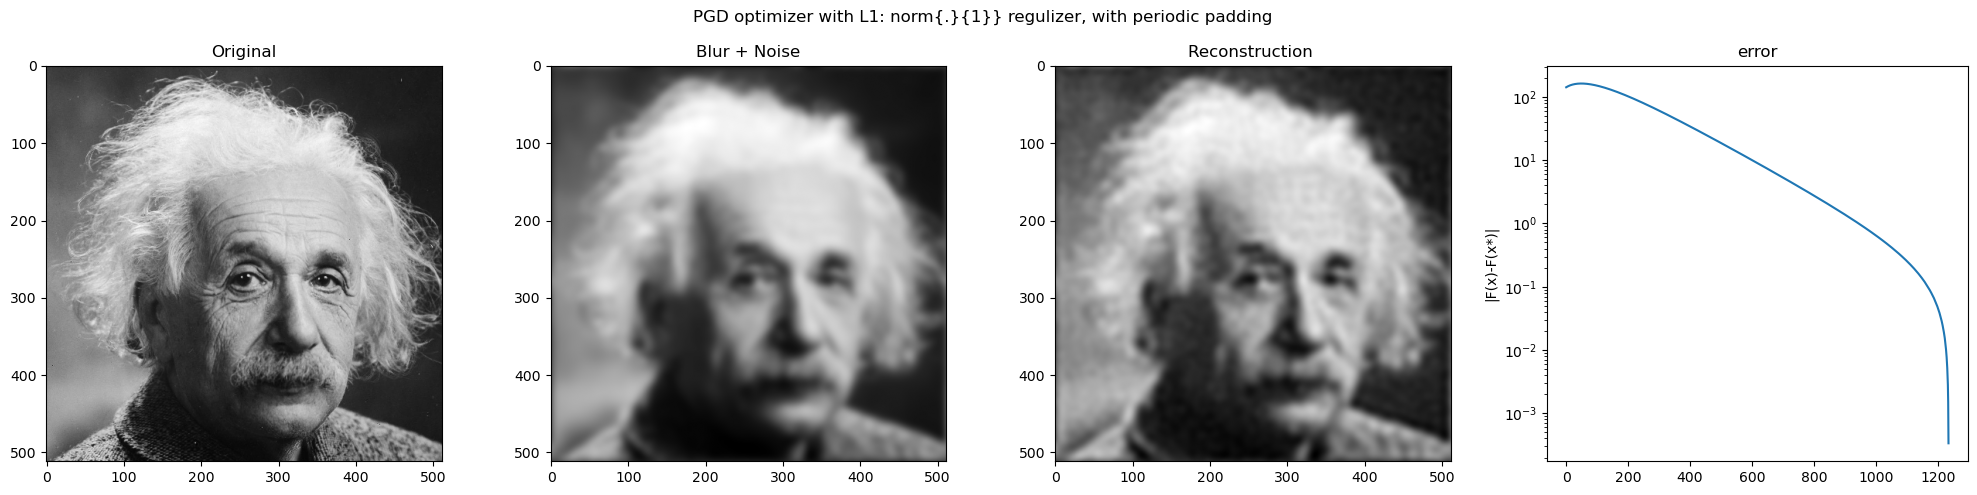

In [155]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('PGD optimizer with L1: norm{.}{1}} regulizer, with periodic padding')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(per_blur_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.semilogy(error)
ax4.set_title('error') 
ax4.set_ylabel('|F(x)-F(x*)|')
plt.tight_layout()
plt.show()

- Comments 
Je pense que je prends pas les bons hyperparamtres car lamba = 1e-5 ou 1e-4 c'est tout petit... 
De plus, j'ai l'impression d'etre dans un minimum local car je ne converge pas vers un seul point--> essayer de changer le starting point ?

- TV: \Norm{L.}{1}, model 2: with periodic padding

    - by using denoise_tv_chambolle from skimage library

In [160]:
# here g(x) = ||grad(x)||{1} is not smooth. To solve inverse problem we use PGD with a proximal step

# loss function 
def f(x, y, A):
    fx = jnp.linalg.norm(y-A(x), ord = 'fro')**2
    return fx

# def g(x): 
#     # use forward difference to compute grad_x and grad_y 
#     grad_x = jnp.roll(x, -1, axis=1) - x
#     grad_x = grad_x.at[:,-1].set(0) # (due to forward differences approx)

#     grad_y = jnp.roll(x, -1, axis=0) - x
#     grad_y = grad_y.at[-1].set(0) # (due to forward differences approx)

#     return gx

# @jax.jit
def TV_L1_optimizer_step(x, y, A, alpha, lam):  # alpha = step size
    grads_val = jax.grad(f)(x, y, A)
    # print(grads_val)
    
    # GD update
    z = x - alpha * grads_val

    # proximal step 
    x_new = ski.restoration.denoise_tv_chambolle(z, weight=lam)
    # print(type(x_new))

    # projection
    # x_new = jnp.clip(x_new, 0, 255)
    
    # objectiv value 
    # Fx_new = f(x_new,y, A) + g(x_new)
    # return x_new, Fx_new
    return x_new 

In [167]:
# init
x = jnp.zeros(img.shape)
y = jnp.array(per_blur_noise_img)
A = Model_periodic_padding(jnp.array(img_kernel))
# Fx_true = f(img, y, A) + g(img)
# Fx_init = f(x, y, A) + g(x)
# error = []
# error.append(Fx_init-Fx_true)

# optimization parameters
L = jnp.max(jnp.abs(A.img_kernel_f))
alpha = 1e-3
lam = 0.01
n_iter = 100

# solve 
for _ in tqdm(range(n_iter)):
    # x, Fx = L1_optimizer_step(x, y, A, alpha, tau) 
    x = TV_L1_optimizer_step(x, y, A, alpha, lam) 

    # error.append(Fx-Fx_true)

100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


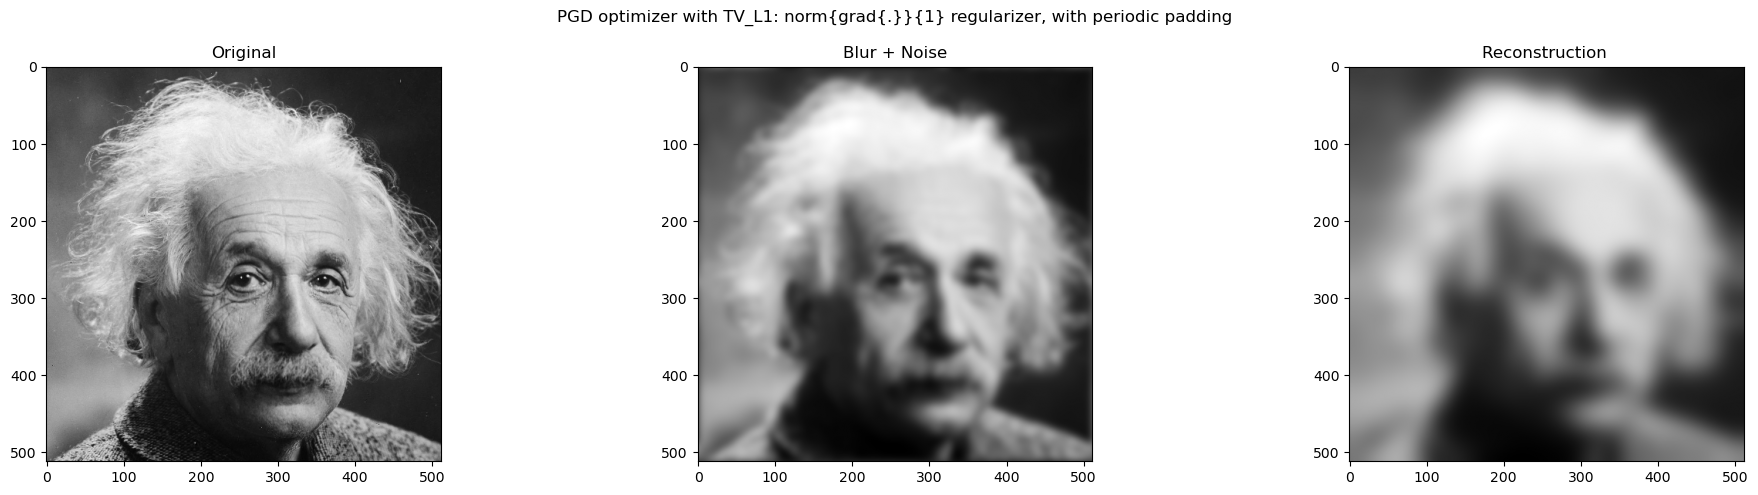

In [ ]:
# plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(20,5))
fig.suptitle('PGD optimizer with TV_L1: norm{grad{.}}{1} regularizer, with periodic padding')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(per_blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
# ax4.loglog(error)
# ax4.set_title('error')
# ax4.set_ylabel('F(x)-F(x*)')
plt.tight_layout()
plt.show()

    - By using explicitly the autodifferentiation from jax

In [5]:
# recall loss =  F(x) = f(x) + lam* g(x) with f(x) = ||y-Ax||{2}^{2} and g(x) = ||grad(.)||_{1} which is not smooth.

# loss functions 
def f(x, y, A):
    fx = jnp.linalg.norm(y-A(x), ord = 'fro')**2
    return fx

def g(x): 

    # use forward difference to compute grad_x and grad_y 
    grad_x = jnp.roll(x, -1, axis=1) - x
    grad_x = grad_x.at[:,-1].set(0) # (due to forward differences approx)

    grad_y = jnp.roll(x, -1, axis=0) - x
    grad_y = grad_y.at[-1].set(0) # (due to forward differences approx)

    # compute l1 norm of grad(.) (grad(.) return a vector)
    gx= jnp.sum(jnp.abs(grad_x)) + jnp.sum(jnp.abs(grad_y))
    return gx

# loss
def loss_TV_l1(x, y, A, lam):
    Fx = f(x, y, A) + lam* g(x)
    return Fx

@jax.jit
def autodiff_TV_L1_optimizer_step(x, y, A, alpha, lam):  # alpha = step size
    loss_val, grads_val = jax.value_and_grad(loss_TV_l1)(x, y, A, lam)
    # print(grads_val)
    
    # GD update
    x_new = x - alpha * grads_val

    return x_new, loss_val  

In [45]:
# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(per_blur_noise_img)
A = Model_periodic_padding(jnp.array(img_kernel))


# optimization parameters
alpha = 1e-5
n_iter = 500
lam = 0.05

losses = []
# solve 
for _ in tqdm(range(n_iter)):
    x, loss_val = autodiff_TV_L1_optimizer_step(x, y, A, alpha, lam) 
    losses.append(loss_val) 

100%|██████████| 500/500 [00:04<00:00, 115.96it/s]


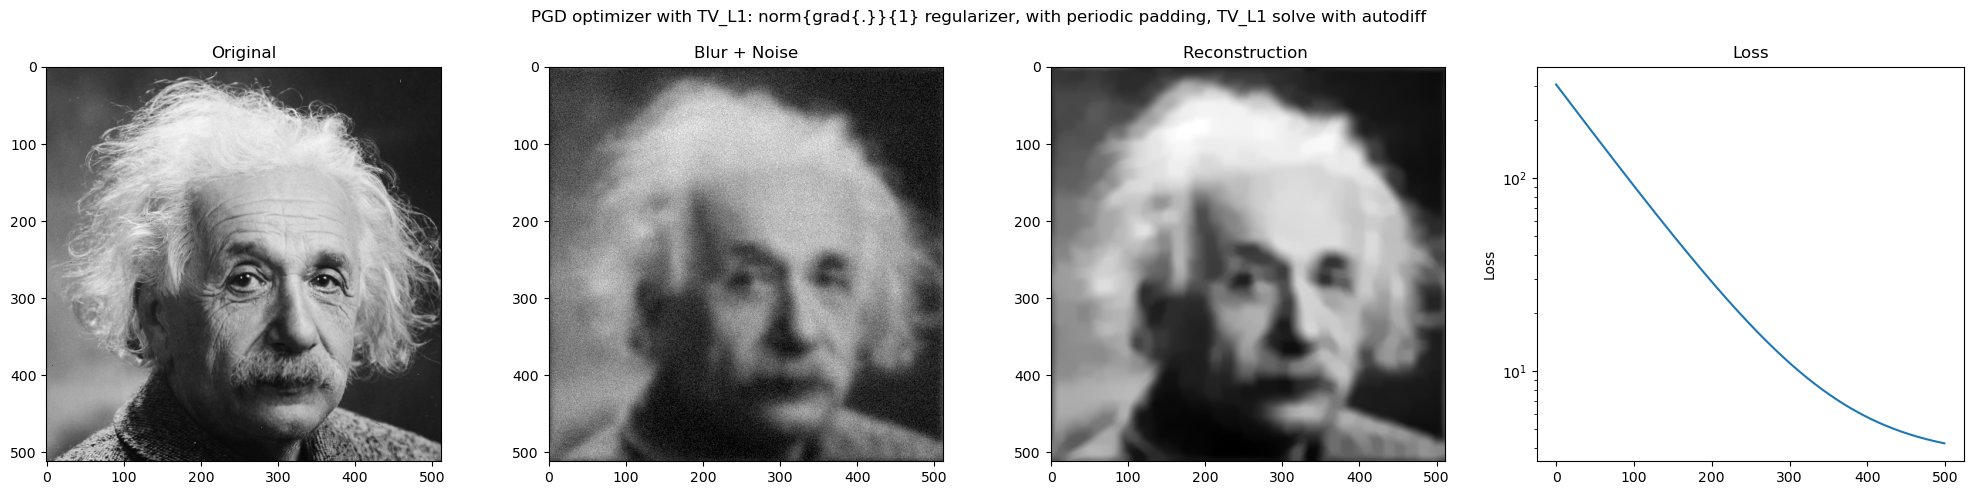

In [46]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('PGD optimizer with TV_L1: norm{grad{.}}{1} regularizer, with periodic padding, TV_L1 solve with autodiff')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(per_blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.semilogy(losses)
ax4.set_title('Loss') 
ax4.set_ylabel('Loss')
plt.tight_layout()
plt.show()

# PnP denoiser with trained NN (MAXIM)

## Define NN model

In [3]:
# import model helper functions 
from run_eval import *
%reload_ext autoreload
%autoreload 2

In [ ]:
# define model
ckpt_path = 'maxim/data/ckpt_Denoising_SIDD.npz'
task = 'Denoising'

# config model
params = get_params(ckpt_path) ########### define a class will be better !
model = config_model(task)

# Test on one image

In [ ]:
# predict
pred = apply_model(model, params, per_blur_noise_img)[:,:,0] # get only one channel since i m working with gray scale img 

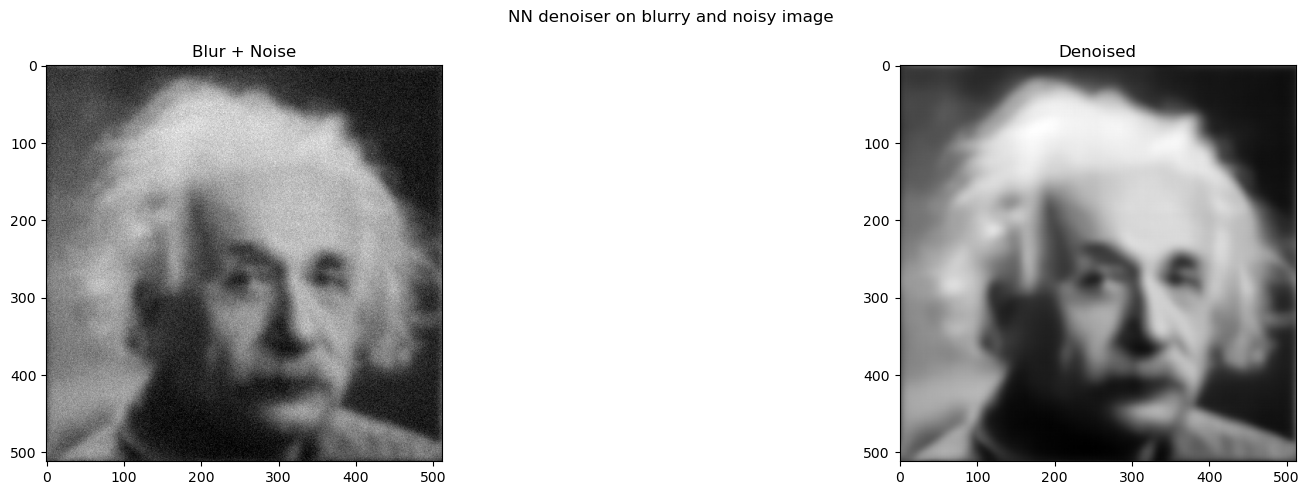

In [9]:
# plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize =(20,5))
fig.suptitle('NN denoiser on blurry and noisy image')
ax1.imshow(per_blur_noise_img, cmap= "gray")
ax1.set_title('Blur + Noise')
ax2.imshow(pred, cmap= "gray")
ax2.set_title('Denoised')
plt.tight_layout()
plt.show()

# PnP

In [10]:
# here "g(x)" correspond to NN denoiser, hence the loss function will only include f(x) ################## check

# loss function 
def f(x, y, A):
    fx = jnp.linalg.norm(y-A(x), ord = 'fro')**2
    return fx

# @jax.jit
#################### to change, put model and params inside a class for more comprehensivity
def PnP_optimizer_step(x, y, A, alpha, model, params):  # alpha = step size
    grads_val = jax.grad(f)(x, y, A)
    
    # GD update
    z = x - alpha * grads_val

    # PnP step 
    x_new = apply_model(model, params, z)[:,:,0] # get only one channel since i m working with gray scale img 
    
    return x_new 

In [ ]:
# ajouter Ou retrouver le file chkpt pour le model !!!!!!!!!!!!!